In [1]:
import numpy as np
import pandas as pd
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from tools import *
from plot import *

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
indiana_class_names = np.arange(n_cluster_indiana).astype(str)
salinas_class_names = np.arange(n_cluster_salinas).astype(str)

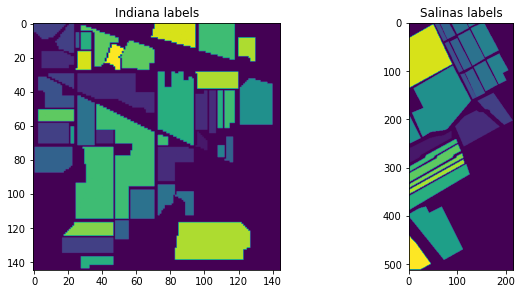

In [8]:
# Display ground truth for each image
plot_two_figures(indiana_labels, salinas_labels, title_fig1='Indiana labels', title_fig2='Salinas labels')

## Remove unclassified data

We will use a supervised learning algorithm. We have to remove data without labels (considered as the background of the ground truth) to allow our model to recognize the different classes. 

In [9]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [10]:
indiana_labels, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [11]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [12]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


After retrieving the optimal number of components for each image, we need to compute a second PCA for each image to extract their features.

In [13]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [14]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split data into train / test

We will use a supervised learning algorithm. We need to split our dataset into training and testing dataset. To be sure that our splitting is efficient, we decided to split data for each label.
In addition, we decided to shuffle our data so that the split does not return us the first values of each label in the ground truth. 

We are going to use 75% of the data as the training dataset and 25% for the testing.



If we split directly over all the data, it is possible that all the samples of a class are in the train data (when the class contains few samples).

In [15]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels)

In [16]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [17]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [18]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

Cluster: 0
Nb total samples: 46
Nb samples train: 34
Nb samples test: 12
---------------
Cluster: 1
Nb total samples: 1428
Nb samples train: 1071
Nb samples test: 357
---------------
Cluster: 2
Nb total samples: 830
Nb samples train: 622
Nb samples test: 208
---------------
Cluster: 3
Nb total samples: 237
Nb samples train: 177
Nb samples test: 60
---------------
Cluster: 4
Nb total samples: 483
Nb samples train: 362
Nb samples test: 121
---------------
Cluster: 5
Nb total samples: 730
Nb samples train: 547
Nb samples test: 183
---------------
Cluster: 6
Nb total samples: 28
Nb samples train: 21
Nb samples test: 7
---------------
Cluster: 7
Nb total samples: 478
Nb samples train: 358
Nb samples test: 120
---------------
Cluster: 8
Nb total samples: 20
Nb samples train: 15
Nb samples test: 5
---------------
Cluster: 9
Nb total samples: 972
Nb samples train: 729
Nb samples test: 243
---------------
Cluster: 10
Nb total samples: 2455
Nb samples train: 1841
Nb samples test: 614
-----------

In [19]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

Cluster: 0
Nb total samples: 2009
Nb samples train: 1506
Nb samples test: 503
---------------
Cluster: 1
Nb total samples: 3726
Nb samples train: 2794
Nb samples test: 932
---------------
Cluster: 2
Nb total samples: 1976
Nb samples train: 1482
Nb samples test: 494
---------------
Cluster: 3
Nb total samples: 1394
Nb samples train: 1045
Nb samples test: 349
---------------
Cluster: 4
Nb total samples: 2678
Nb samples train: 2008
Nb samples test: 670
---------------
Cluster: 5
Nb total samples: 3959
Nb samples train: 2969
Nb samples test: 990
---------------
Cluster: 6
Nb total samples: 3579
Nb samples train: 2684
Nb samples test: 895
---------------
Cluster: 7
Nb total samples: 11271
Nb samples train: 8453
Nb samples test: 2818
---------------
Cluster: 8
Nb total samples: 6203
Nb samples train: 4652
Nb samples test: 1551
---------------
Cluster: 9
Nb total samples: 3278
Nb samples train: 2458
Nb samples test: 820
---------------
Cluster: 10
Nb total samples: 1068
Nb samples train: 801


In [20]:
print("Indiana - Train shape: {}".format(x_train_indiana.shape))
print("Indiana - Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Indiana - Test shape: {}".format(x_test_indiana.shape))
print("Indiana - Test labels shape: {}".format(y_test_indiana_labels.shape))

Indiana - Train shape: (7680, 68)
Indiana - Train labels shape: (7680,)
Indiana - Test shape: (2569, 68)
Indiana - Test labels shape: (2569,)


In [21]:
print("Salinas - Train shape: {}".format(x_train_salinas.shape))
print("Salinas - Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Salinas - Test shape: {}".format(x_test_salinas.shape))
print("Salinas - Test labels shape: {}".format(y_test_salinas_labels.shape))

Salinas - Train shape: (40592, 5)
Salinas - Train labels shape: (40592,)
Salinas - Test shape: (13537, 5)
Salinas - Test labels shape: (13537,)


We can display the histograms to verify that our split is working well and that no data is lost.

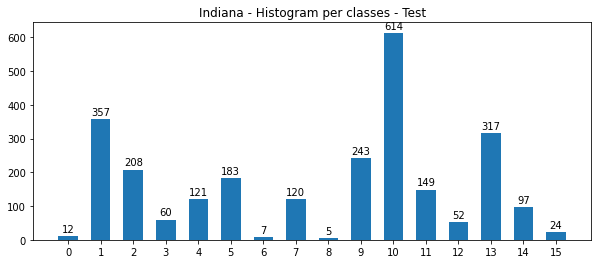

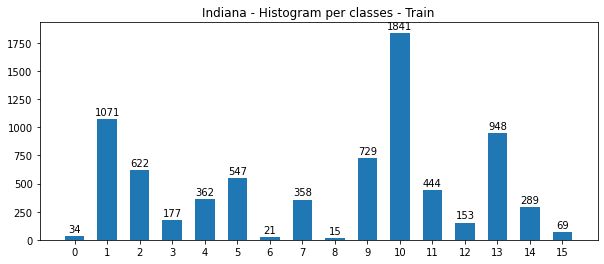

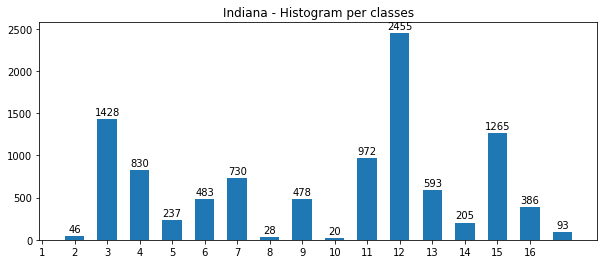

In [22]:
plot_histogram(y_test_indiana_labels, title='Indiana - Histogram per classes - Test')
plot_histogram(y_train_indiana_labels, title='Indiana - Histogram per classes - Train')
plot_histogram(indiana_labels, title='Indiana - Histogram per classes')

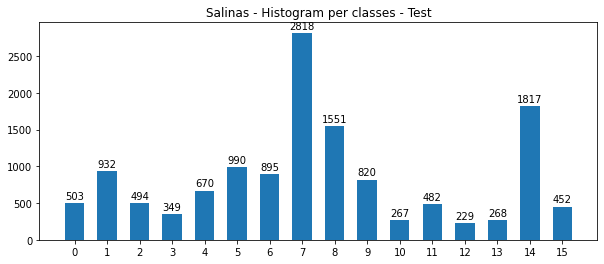

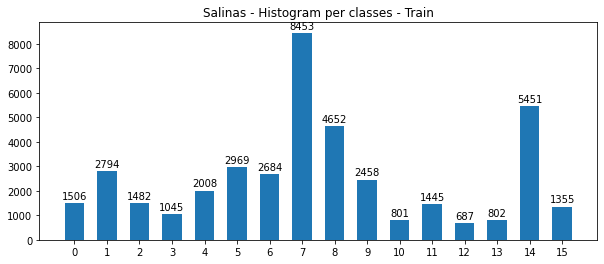

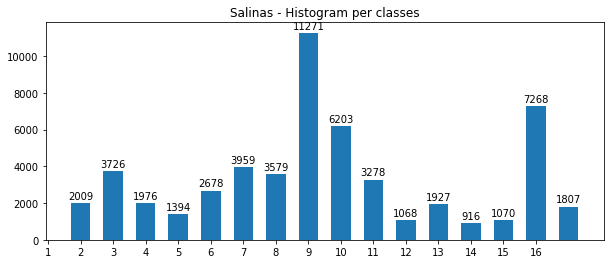

In [23]:
plot_histogram(y_test_salinas_labels, title='Salinas - Histogram per classes - Test')
plot_histogram(y_train_salinas_labels, title='Salinas - Histogram per classes - Train')
plot_histogram(salinas_labels, title='Salinas - Histogram per classes')

We can see that the histogram variations are the same for each data set, which means there is no loss of information. 

# OneVsOneClassifier using LinearSVC

### LinearSVC

LinearSVC stands for Linear Support Vector Classification.

LinearSVC is an implementation of SVC using a linear kernel.
SVC uses the Support Vector Domain Description (SVDD) to delineate the region in data space using a kernel function. With a linear kernel, SVDD simulate the smallest sphere that encloses the data. Those contours are then interpreted as cluster boundaries, and points enclosed by each contour are associated by SVC to the same cluster. 

### OneVsOneClassifier

OneVsOneClassifier constructs a classifier for each pair of classes. During the prediction, the class with the highest votes is returned. If two classes have the same number of votes, the class with the highest aggregate classification confidence is returned.

In [24]:
indiana_modelSVC = LinearSVC(random_state=0, verbose=1)
salinas_modelSVC = LinearSVC(random_state=0, verbose=1)

In [25]:
indiana_model = OneVsOneClassifier(indiana_modelSVC, n_jobs=8)
salinas_model = OneVsOneClassifier(salinas_modelSVC, n_jobs=8)

In [26]:
indiana_model.fit(x_train_indiana, y_train_indiana_labels)

OneVsOneClassifier(estimator=LinearSVC(random_state=0, verbose=1), n_jobs=8)

In [27]:
salinas_model.fit(x_train_salinas, y_train_salinas_labels)

OneVsOneClassifier(estimator=LinearSVC(random_state=0, verbose=1), n_jobs=8)

In [28]:
indiana_training_score = indiana_model.score(x_train_indiana, y_train_indiana_labels)
indiana_testing_score = indiana_model.score(x_test_indiana, y_test_indiana_labels)

print('Indiana - training score: {}'.format(indiana_training_score))
print('Indiana - testing score: {}'.format(indiana_testing_score))

print()

salinas_training_score = salinas_model.score(x_train_salinas, y_train_salinas_labels)
salinas_testing_score = salinas_model.score(x_test_salinas, y_test_salinas_labels)

print('Salinas - training score: {}'.format(salinas_training_score))
print('Salinas - testing score: {}'.format(salinas_testing_score))

Indiana - training score: 0.704296875
Indiana - testing score: 0.6819774231218373

Salinas - training score: 0.8810356720536067
Salinas - testing score: 0.8778163551747064


We can notice that the scores of the train and the tests are very close which means that our models do not overfit. 

In [29]:
indiana_preds_test = indiana_model.predict(x_test_indiana)
indiana_preds_train = indiana_model.predict(x_train_indiana)

salinas_preds_test = salinas_model.predict(x_test_salinas)
salinas_preds_train = salinas_model.predict(x_train_salinas)

Indiana's score reaches almost 0.70. Now we want to know which classes are more easily recognized than the others and which are not at all.

We can display a histogram containing the number of expected and predicted labels. 

Analyzing our results from a histogram only allows us to determine the number of images per class. We therefore lose a certain amount of information, including the differentiation between false positives and false negatives for each class. This method therefore makes it possible to have a global idea of the efficiency of our model but we cannot deduce much information from it.

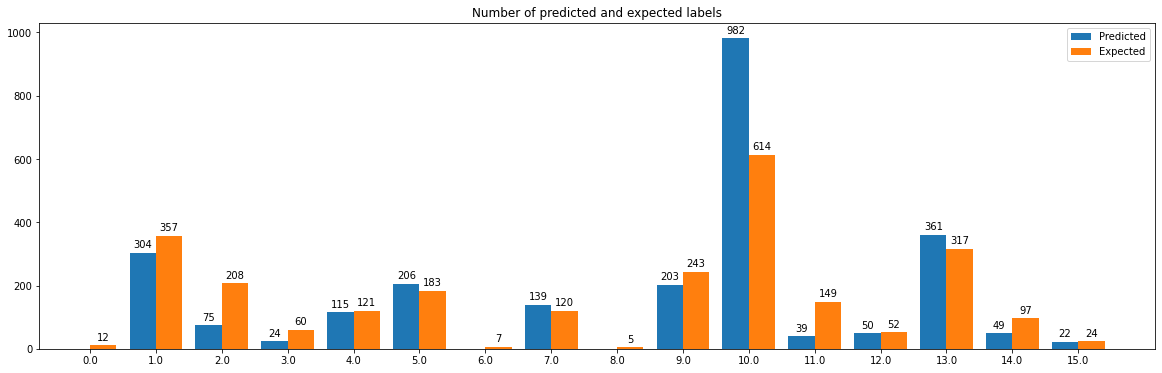

In [30]:
plot_histogram_compare_predict_expect(indiana_preds_test, y_test_indiana_labels)

As we can see, our model cannot recognize classes with less than 20 samples well but we do not know in which class these samples were classified. 

We will display a confusion matrix.
A confusion matrix is used to highlight false positives and false negatives. The diagonal corresponds to the true positive which makes it possible to visualize more easily the classes having fairly large prediction errors.

By the way, we decided to display this matrix using coloring. This can be done using a linear or logarithmic scale. The logarithmic scale makes it possible to highlight the different variations. 

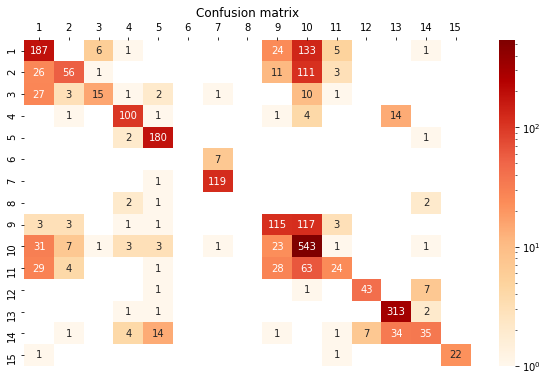

In [31]:
plot_confusion_matrix(y_test_indiana_labels, indiana_preds_test, class_names=np.arange(1, 16), log=True)

A row corresponds to the number of expected labels and a column is the number that we predicted.

We can see that our model does not recognize the 6th label and classified them to the 7th class. 
Our model recognizes only 50% of the samples of class 1 whereas the histogram suggests that 85% of the data were well recognized. 

A classification report contains informations based on true positives, false positives and false negative:
* precision: the number of true positives divided by the number of false positives plus true positives
* recall:  the number of true positives divided by the number of true positives plus false negatives
* f1-score: harmonic mean of the model's precision and recall
* support: the number of occurrence



In [32]:
print(classification_report(y_test_indiana_labels, indiana_preds_test, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.52      0.57       357
           2       0.75      0.27      0.40       208
           3       0.62      0.25      0.36        60
           4       0.87      0.83      0.85       121
           5       0.87      0.98      0.93       183
           6       0.00      0.00      0.00         7
           7       0.86      0.99      0.92       120
           8       0.00      0.00      0.00         5
           9       0.57      0.47      0.52       243
          10       0.55      0.88      0.68       614
          11       0.62      0.16      0.26       149
          12       0.86      0.83      0.84        52
          13       0.87      0.99      0.92       317
          14       0.71      0.36      0.48        97
          15       1.00      0.92      0.96        24

    accuracy                           0.68      2569
   macro avg       0.61   

/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the classification report, we can notice that the for class 10, the precision is only about 0.57 whereas recall is 0.86. This means that our model does not recognize well this class.

We can also perform the same operations for salinas image.

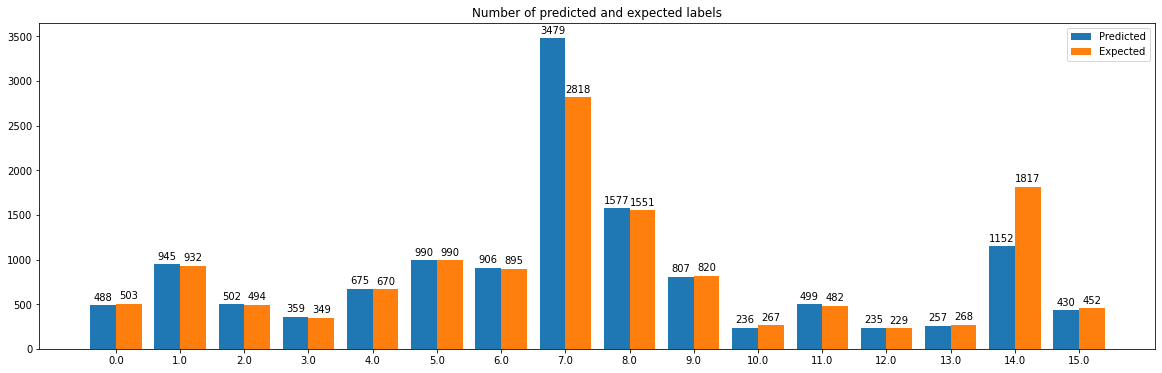

In [33]:
plot_histogram_compare_predict_expect(salinas_preds_test, y_test_salinas_labels)

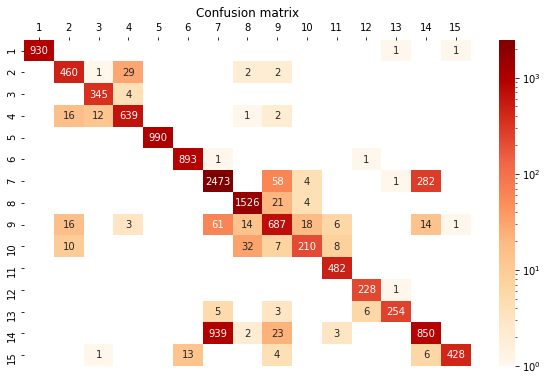

In [34]:
plot_confusion_matrix(y_test_salinas_labels, salinas_preds_test, class_names=np.arange(1, 16), log=True)

In [35]:
print(classification_report(y_test_salinas_labels, salinas_preds_test, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       503
           1       0.98      1.00      0.99       932
           2       0.92      0.93      0.92       494
           3       0.96      0.99      0.97       349
           4       0.95      0.95      0.95       670
           5       1.00      1.00      1.00       990
           6       0.99      1.00      0.99       895
           7       0.71      0.88      0.79      2818
           8       0.97      0.98      0.98      1551
           9       0.85      0.84      0.84       820
          10       0.89      0.79      0.83       267
          11       0.97      1.00      0.98       482
          12       0.97      1.00      0.98       229
          13       0.99      0.95      0.97       268
          14       0.74      0.47      0.57      1817
          15       1.00      0.95      0.97       452

    accuracy                           0.88     13537
   macro avg       0.93   

The classification on this image is obviously better. This is mainly due to the fact that all classes have at least 200 samples. 

### Prediction on images

In [36]:
preds_indiana = indiana_model.predict(X_indiana_reduced)
preds_salinas = salinas_model.predict(X_salinas_reduced)

In [37]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_label_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))

In [38]:
indiana_preds_img[X_indiana_idx] = preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

In [39]:
indiana_label_img[X_indiana_idx] = indiana_labels
indiana_label_img = indiana_label_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

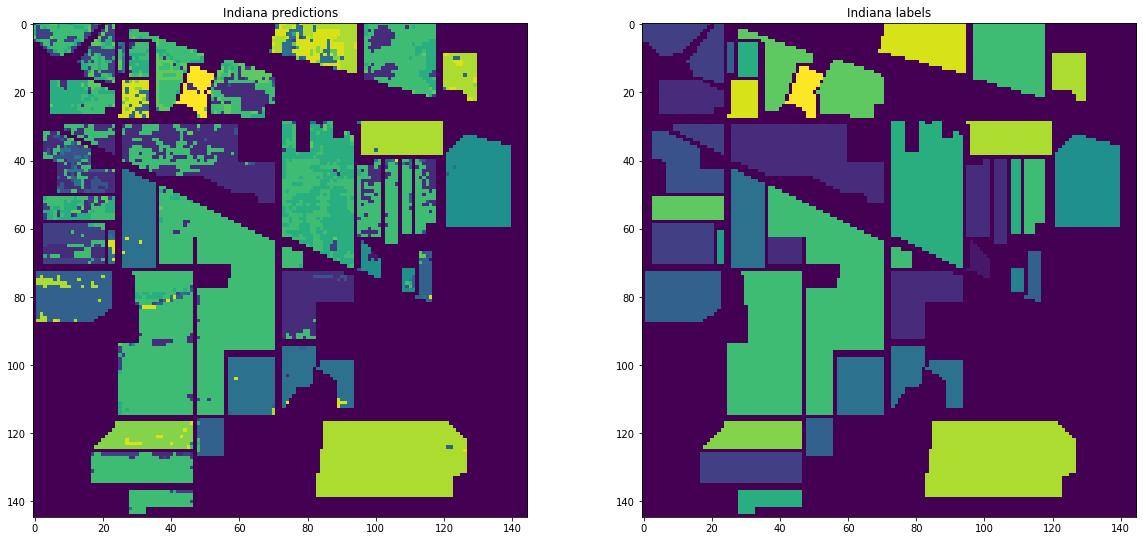

In [40]:
plot_two_figures(indiana_preds_img, indiana_label_img, 'Indiana predictions', 'Indiana labels', figsize=(20, 20))

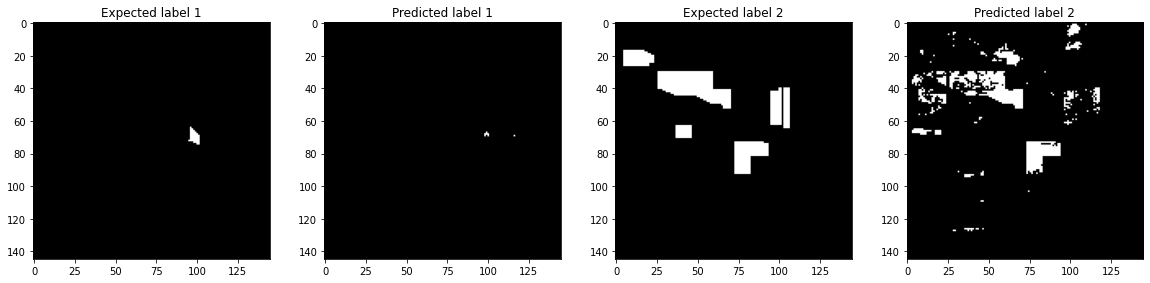

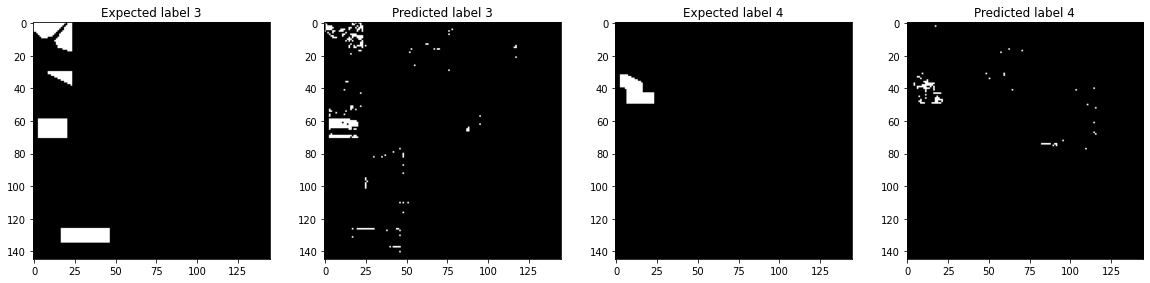

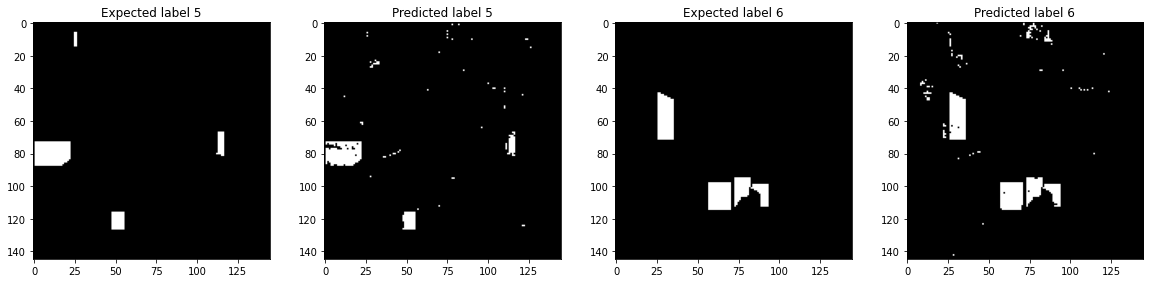

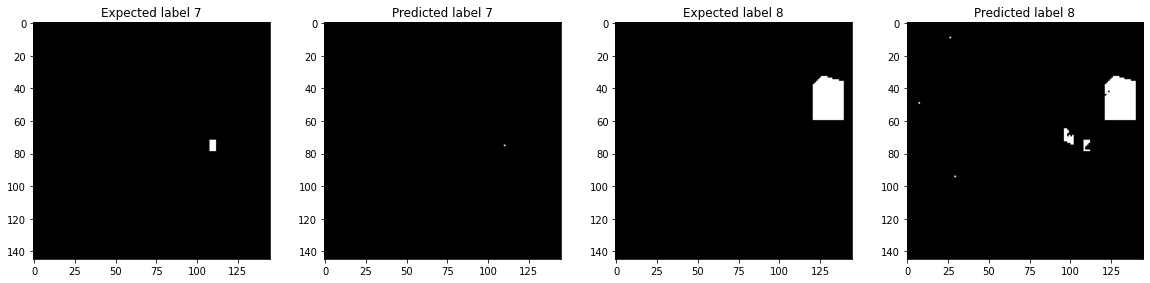

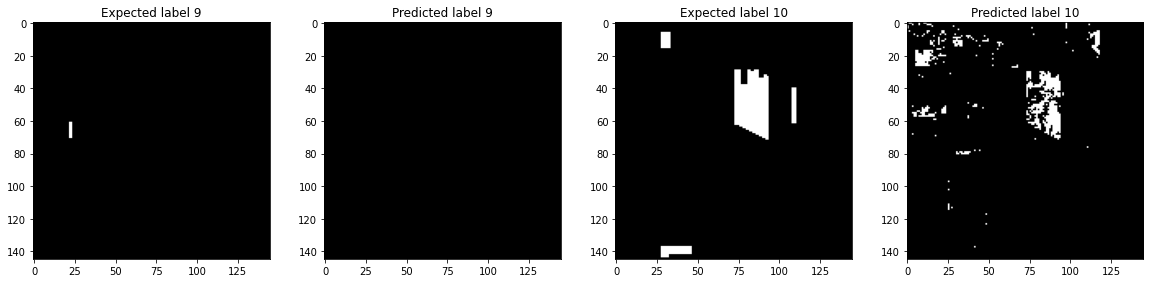

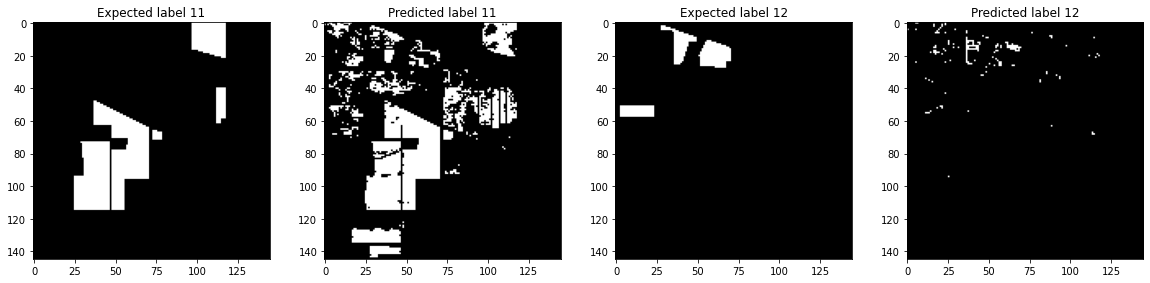

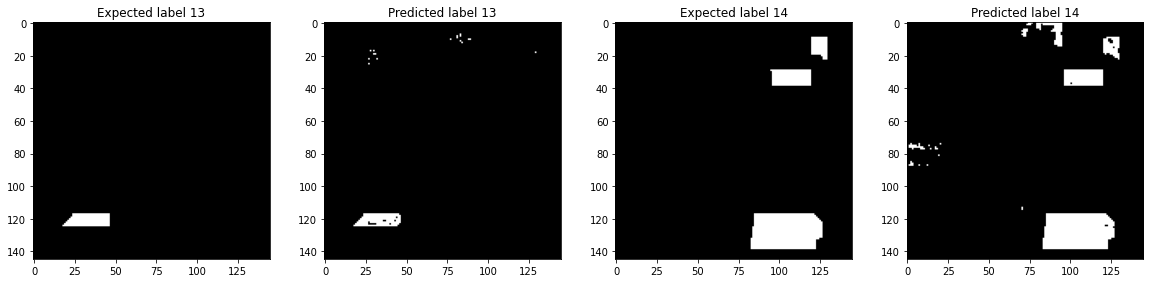

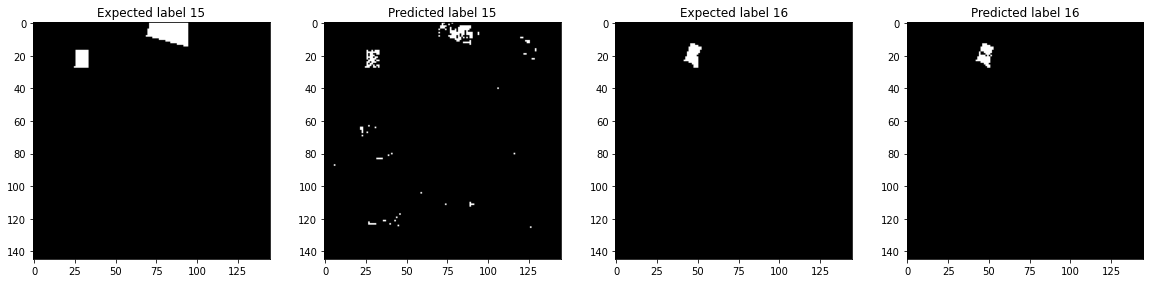

In [41]:
plot_each_labels(indiana_label_img, indiana_preds_img, n_cluster_indiana, figsize=(20, 20), cmap='gray')

We can see that the model is able to recognize all classes although there is still a lot of noise especially for labels 11 and 12.

In [42]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_label_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))

In [43]:
salinas_preds_img[X_salinas_idx] = preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [44]:
salinas_label_img[X_salinas_idx] = salinas_labels
salinas_label_img = salinas_label_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

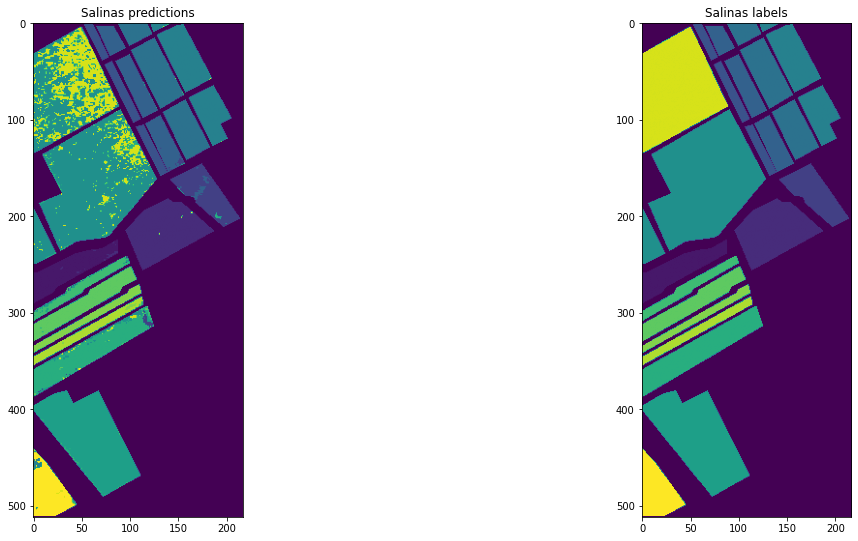

In [45]:
plot_two_figures(salinas_preds_img, salinas_label_img, 'Salinas predictions', 'Salinas labels', figsize=(20, 20))

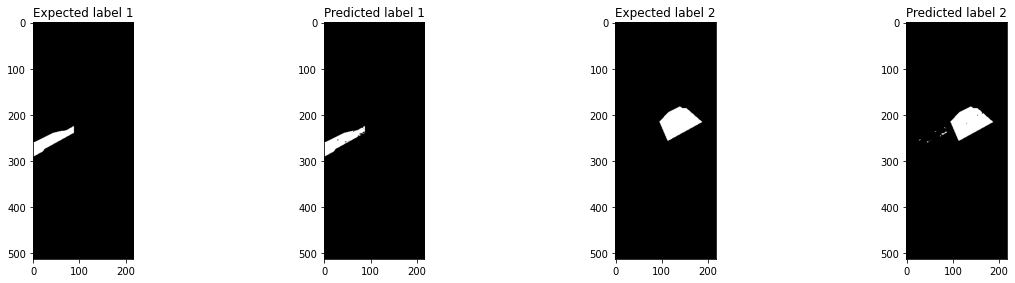

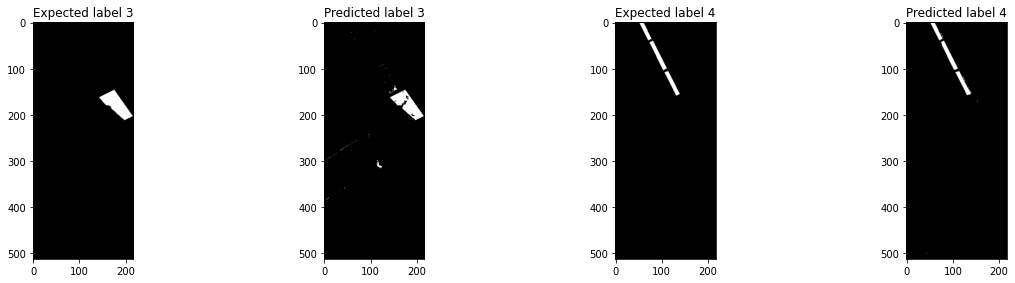

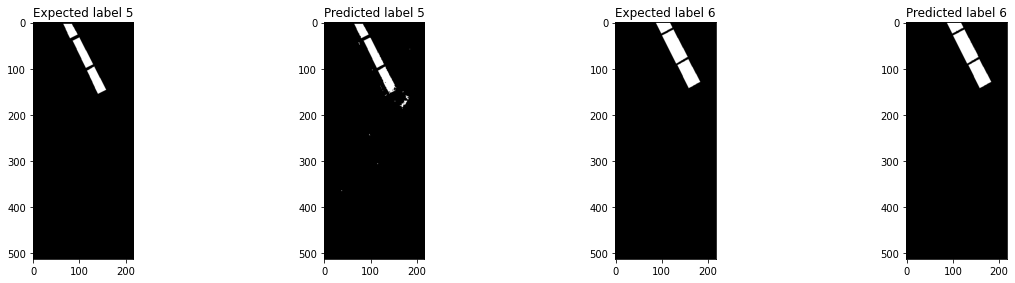

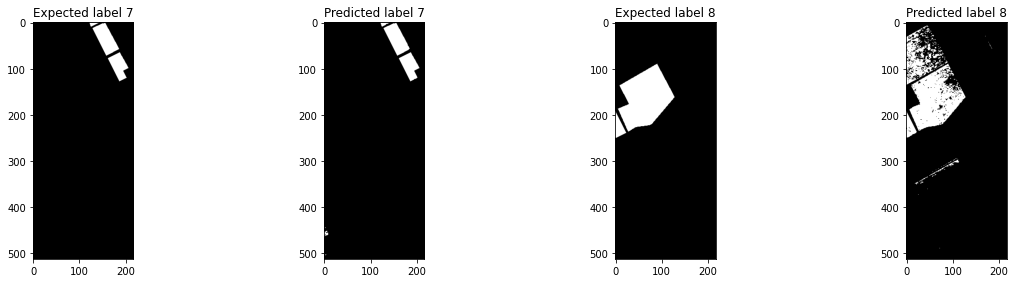

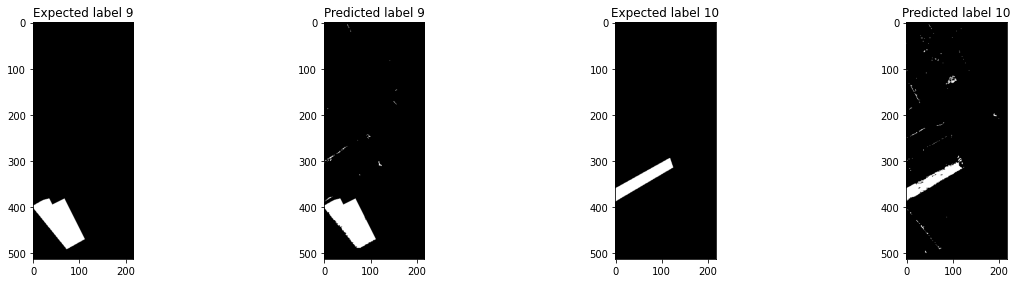

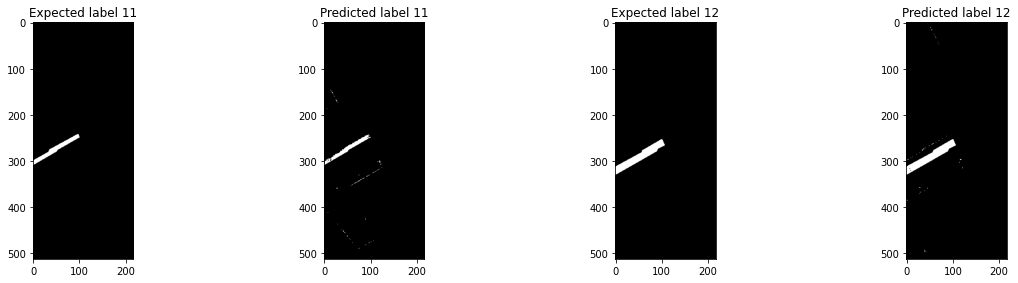

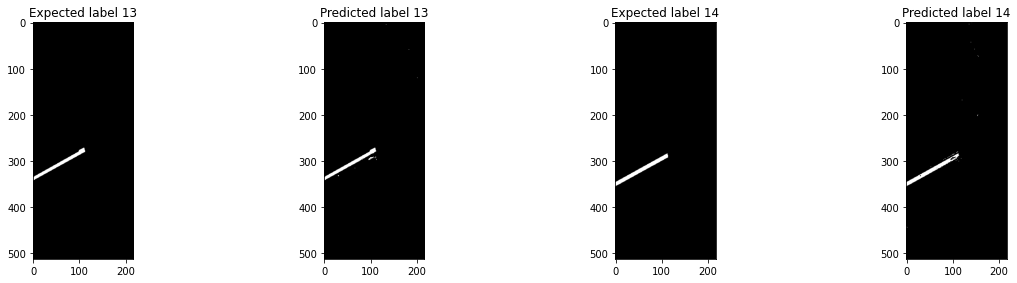

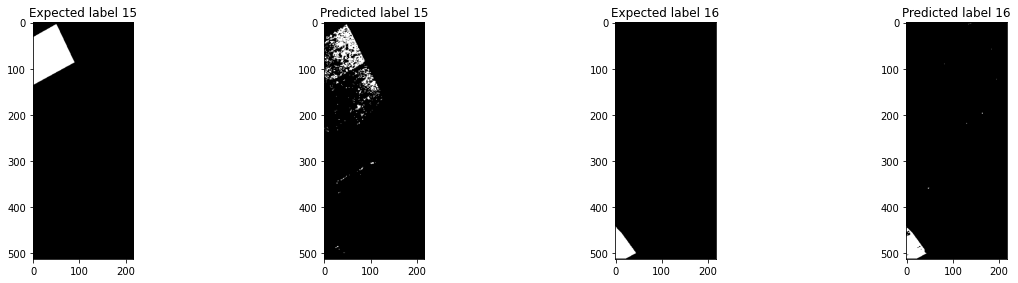

In [46]:
plot_each_labels(salinas_label_img, salinas_preds_img, n_cluster_salinas, figsize=(20, 20), cmap='gray')

We can see that the model is able to recognize all classes although there is still a lot of noise especially for labels 8 and 15.

In [47]:
print(classification_report(indiana_label_img.flatten(), indiana_preds_img.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10776
         1.0       0.86      0.13      0.23        46
         2.0       0.63      0.55      0.59      1428
         3.0       0.78      0.31      0.44       830
         4.0       0.71      0.30      0.42       237
         5.0       0.88      0.86      0.87       483
         6.0       0.86      0.98      0.91       730
         7.0       1.00      0.04      0.07        28
         8.0       0.89      1.00      0.94       478
         9.0       0.00      0.00      0.00        20
        10.0       0.58      0.48      0.53       972
        11.0       0.57      0.89      0.69      2455
        12.0       0.61      0.19      0.29       593
        13.0       0.92      0.93      0.92       205
        14.0       0.89      0.98      0.93      1265
        15.0       0.76      0.43      0.55       386
        16.0       0.99      0.91      0.95        93

    accuracy              

/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print(classification_report(salinas_label_img.flatten(), salinas_preds_img.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56975
         1.0       1.00      0.97      0.99      2009
         2.0       0.99      1.00      0.99      3726
         3.0       0.92      0.93      0.92      1976
         4.0       0.98      0.99      0.98      1394
         5.0       0.95      0.96      0.96      2678
         6.0       1.00      1.00      1.00      3959
         7.0       0.98      0.99      0.99      3579
         8.0       0.71      0.89      0.79     11271
         9.0       0.97      0.98      0.98      6203
        10.0       0.86      0.84      0.85      3278
        11.0       0.89      0.83      0.86      1068
        12.0       0.96      1.00      0.98      1927
        13.0       0.95      0.98      0.96       916
        14.0       0.97      0.93      0.95      1070
        15.0       0.75      0.47      0.58      7268
        16.0       0.99      0.94      0.97      1807

    accuracy              

We decided to display classification report on the whole image to have an idea about how many percent of each class is recognized. However, the model predicts on training and testing data.

In general, OneVsOneClassifier with LinearSVC is good enough to distinguish each class. The average score is at least 0.70 but classes containing a few sample are not recognized at all.

## Save predictions

In order to be able to compare models , we save our prediction data on each image. We also save model's score.

In [49]:
np.save('../data/predictions/indiana_preds_linearSVC.npy', indiana_preds_img)
np.save('../data/predictions/salinas_preds_linearSVC.npy', salinas_preds_img)

In [50]:
# Check if csv file exists
try:
    df = pd.read_csv('../data/score.csv')
except Exception:
    cols = ['model', 'image', 'score_test', 'score_train']
    df = pd.DataFrame(columns=cols)

In [51]:
df.loc[df.size] = ['OneVsOneClassifier - LinearSVC', 'indiana', indiana_testing_score, indiana_training_score]
df.loc[df.size] = ['OneVsOneClassifier - LinearSVC', 'salinas', salinas_testing_score, salinas_training_score]

In [52]:
df.to_csv('../data/score.csv', index=False)